In [6]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))


from btlib.data.loader import load_price
from btlib.core.engine import Backtest
from btlib.analytics.metrics import compute_basic_metrics

from btlib.core.strategy import Strategy

import pandas as pd
import numpy as np

from btlib.indicators.basic import sma

class SMACrossLongOnly(Strategy):    
    def on_start(self):
        window = self.params.get("window", 20)
        self.data["sma"] = sma(self.data["Close"], window)
    
    def on_bar(self):
        rng = np.random.default_rng(seed=36)
        bar = self.current_bar
        ts = self.current_time

        if pd.isna(bar["sma"]):
            return []

        signals = []
        if bar["Close"] > bar["sma"]:
            signals.append(self.buy(size=self.params.get("size", 1.0)))
        elif bar["Close"] < bar["sma"]:
            if rng.random() % 2 == 1:
                signals.append(self.sell(size=self.params.get("size", 1.0)))
        
        return signals


df = load_price("input/AAPL_1h_twelvedata.csv")
bt = Backtest(
    data=df,
    symbol="AAPL",
    strategy_class=SMACrossLongOnly,
    initial_cash=10000,
    window=20,
    size=0.1
)
result = bt.run()

metrics = compute_basic_metrics(result.equity_curve)
print(metrics)


{'total_return': -0.04359094951000153, 'avg_return': -9.951371114290672e-05, 'volatility': 0.00200367633179982, 'sharpe': -0.04966556202893191, 'max_drawdown': -0.04783853051913278}


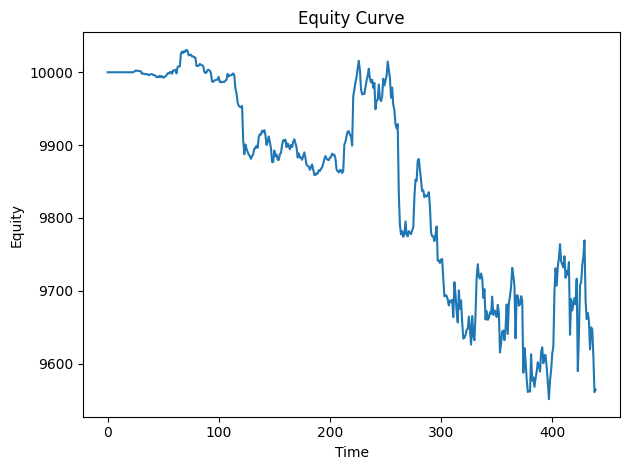

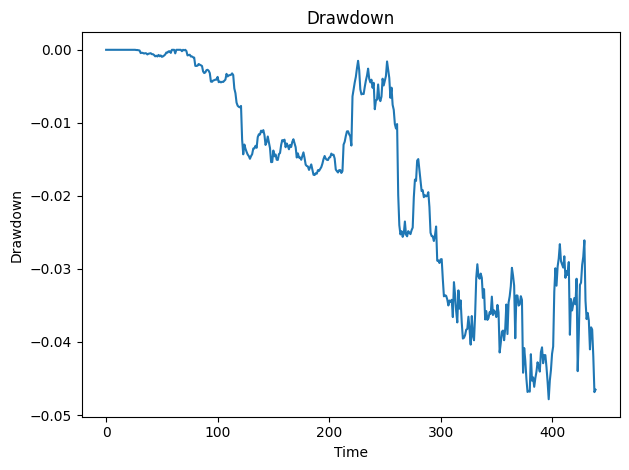

In [7]:
from btlib.analytics.visualization import plot_equity_curve, plot_drawdown

plot_equity_curve(result.equity_curve)
plot_drawdown(result.equity_curve)